In [45]:
# standard tools in Python for economists
import numpy as np 
from   numpy import linspace, logspace, log, exp, sqrt, bmat, zeros, ones, round
from numpy.linalg import inv, norm, eig
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.interpolate import interp1d
from numba import jit, njit, guvectorize  # vectorizes loops to improve performance
from numpy.matlib import repmat
# pip install quantecon  ### run this the first time you install quantecon
import quantecon as qe
from quantecon import MarkovChain

# Problem 2

In [69]:
β = .96
r = .03
γ = 1
u = lambda c, γ: c**(1-γ)/(1-γ) if γ!=1 else log(c) #utility function
u1 = lambda c, γ: c**(-γ) #u'
u1inv = lambda u1, γ: u1**(-1/γ) #u' inverse

e_backward = 1e-10 # backward iteration tolerance
imax_backward = 1e5 # max iterations for backward iteration

# e_forward = 1e-10 # forward iteration tolerance
# imax_forward = 1e5 # max iterations for forward iteration

# baseline income grid and transition
yL = 1
yH = 2
ns = 2
s_grid = np.array([yL, yH])
Π = np.array([[.95, .05], [.1, .9]]) # transition matrix

# asset grid
amin = 0
amax = 100
na = 1000

# Interest rate grid
nR = 10
R_grid = np.linspace(1,1/β, num=nR)

In [47]:
def prepare(yL=yL, amin=amin, amax=amax, na=na, θ=0, x=0):
    
    # make grid
    yL=1+x
    yH = 2-x # set high and low income values
    s_grid = np.array([yL, yH]) # set up income grid (1x2)
    
    c = abs(amin) + 1
    a_grid = np.exp(np.linspace(np.log(c+amin), np.log(c+amax), num = na)) - c # exponential grid
    ma_grid, ms_grid = np.meshgrid(a_grid, s_grid) # create grid of assets and income values
    
    # prepare transition matrix
    Π = np.array([[.95-θ, .05+θ], [.1+θ, .9-θ]])
    
    # find stationary earning distribution, useful only in PS4
    s_dist = ones(ns)/ns
    for i in range(1000):
        s_dist = Π.T@s_dist # stationary distribution

    return ma_grid, ms_grid, Π, s_dist

# baseline
ma_grid, ms_grid, Π, s_dist = prepare()
coh = (1+r)*ma_grid + ms_grid # cash on hand

In [48]:
# Here are a few specifications you can play with

# baseline parameters
param_base = {'r': r, 'β': β, 'γ': γ, 'yL': yL, 'θ': 0, 'x': 0, 'amin': 0}

In [49]:
# ---------------------------------------------------
# 1-step backward iteration
def backward1(Va_future, r=r, β=β, γ=γ, ma_grid=ma_grid, coh=coh, Π=Π, report='N'):
    
    Va_future[Va_future < 1e-5] = 1e-5
    cnext = u1inv(β * Π @ Va_future, γ) # cnext is a function of s and a'
        # backing out c using equated marginal utilities across periods
        
    a_policy = ones([ns,na]) #initialize asset policy matrix (2x1000)
    for s in range(ns):  #iterate over states
        x = coh[s,:] # vector showing cash on hand matrix for given income at all possible asset values (1x1000)
        xp = cnext + ma_grid # given that you ended up with assets ma_grid and consumed cnext, you must have started
            # with assets in xp matrix
        xp = xp[s,:] # take the vector from that matrix for your state
        fp = ma_grid[s,:] 
        # np.interp: x to xp is the output to fp
        a_policy[s,:] = np.interp(x, xp, fp)

        
    # set a and c to respect the borrowing limit
    a_policy[a_policy < ma_grid[0,0]] = ma_grid[0,0] # set any elements below lowest asset value to lowest value
    c_policy = coh - a_policy # get consumption from cash on hand and savings decisions
    c_policy[c_policy < 1e-5] = 1e-5 # bring all consumption up to min value
    a_policy = coh - c_policy # recalculate assets based on bounded consumption
    Va = (1+r)*u1(c_policy, γ) # get next value fxn derivative value matrix using new consumption policy
    return Va, a_policy, c_policy

# ---------------------------------------------------
# backward iteration to steady state
def backward(param=param_base, report='N', criterium='Va',\
             error=e_backward, imax=imax_backward): 
    r = param['r']
    β = param['β']
    γ = param['γ']
    
    # make grids
    ma_grid, ms_grid, Π, s_dist = prepare(yL=param['yL'], amin=param['amin'], θ=param['θ'], x=param['x']) #set up grids using parameters
    coh = (1+r)*ma_grid + ms_grid # cash on hand, using return on assets carried into current period plus income in current period
    param.update({'ma_grid': ma_grid, 'ms_grid': ms_grid, 'coh': coh, 
                  'a_grid': ma_grid[0,:], 's_grid': ms_grid[:,0], 'Π': Π, 's_dist': s_dist}) 
        #update all of the parameters based on new grid values
    
    # initial guess to start the iteration. consume 5% of coh
    c_policy0 = .05*coh
    c_policy0[c_policy0 < 1e-5] = 1e-5 # fix any values below min
    Va0 = (1+r)*u1(c_policy0, γ) # get new value function derivative using guessed consumption policy

    if report == 'Y':
        print('-----\nBackward iteration starts.')
    
    i = 0
    e = error+1
    if i == 0:
        Va_old = Va0
        Va_old[Va_old < 1e-5] = 1e-5
        c_policy_old = u1inv(Va_old/(1+r), γ) # get old consumption guess by inverting value fxn derivative
    
    while e > error and i < imax: #while outside of acceptable range and not at max iterations
        Va, a_policy, c_policy = backward1(Va_old, r=r, β=β, γ=γ, ma_grid=ma_grid, coh=coh, Π=Π, report=report)
            #iterate backwards one step
        # convergence criterium block
        if criterium == 'c': # error based on consumption policy
            e = np.max(np.abs(c_policy-c_policy_old))
        elif criterium == 'Va': # error based on Va
            e = np.max(np.abs(Va-Va_old))
        else:
            raise ValueError("criterium has to be 'c' or 'Va'")
        
        #c_policy_old = c_policy # use new c policy as old in next iteration
        Va_old = Va # use new value function derivative as old in next iteration
        i += 1
        if i % 500 == 0 and report == 'Y':
            print('current iteration:', i)
            print('current error:', e)
        
    if i == imax:
        print('Warning! -- used max backward iteration:', imax)
    if report == 'Y':
        print('# of iterations:', i)
        print('error:', e)
        print('Backward iteration ends.\n-----')
        
    return Va, a_policy, c_policy, param 
        # return value derivative, final policies, final parameters one policies/value fxn deriv have converged

In [50]:
Va, a_policy, c_policy, param = backward()

In [51]:
# Defining a function that maps assets a to a 
# grid with probabilities of transitioning to different asset states

# a argument is non-grid a' (i.e., a value output by a policy fxn) 
# that we want to convert into transition probabilities for up to 2 states on the grid
def a_prob(a, ma_grid):
    a_prob_grid = zeros([ns,na])
    for s in range(ns):
        a1_idx = np.argmin(np.abs(np.array(ma_grid[s,:])-a)) # get a1 on grid closest to a
        a1 = ma_grid[s,a1_idx]
        if a < ma_grid[s,a1_idx]: # if a < a1
            a2_idx = a1_idx - 1 # a2 is the closest lower gridpoint
        elif a > ma_grid[s, a1_idx]: # if a > a1
            a2_idx = a1_idx + 1 # a2 is the closest higher gridpoint
        else:
            a2_idx = a1_idx
            a_prob_grid[s, a1_idx] = 1
            continue # move on to next s
        a2 = ma_grid[s,a2_idx]
        # At this point we know closest a1, a2 to a
        # probability of transitioning into a1 = p
        p = (a2 - a)/(a2 - a1)
        a_prob_grid[s, a1_idx] = p
        a_prob_grid[s, a2_idx] = 1-p
    return a_prob_grid

# returns ns x na matrix where e/ cell is the prob of 
# ending up in that asset state given that you started in a

In [52]:
# Define function that generates transition matrix T between (y, a) states
def make_T(a_policy, Π=Π, ma_grid=ma_grid):
    # Π is ns x ns transition matrix for income states
    # a_policy is ns x na matrix, gives a' for starting state (y, a)
    # a_policy is R-specific!
    
    n_states = ma_grid.shape[0] * ma_grid.shape[1] # get number of (y, a) states = N
    T = zeros([n_states, n_states]) # initialize NxN transition matrix
        # T row is [(y1, a1), (y1, a2), ... (y1, a1000), (y2, a1), ... (y2, a1000)]
    for a in range(na): #iterate over starting asset states
        for s in range(ns): # iterate over starting income states
            a_prob_grid = a_prob(a_policy[s, a], ma_grid)
                # get grid showing prob of ending up in e/ asset state after starting in a
            start_idx = na*s + a #get index of start state in T-vector terms
            for s_new in range(ns): # iterate over destination income states
                for a_new in range(na): #iterate over destination asset states
                    end_idx = na*s_new + a_new # get index of end state in T-vector terms
                    T[start_idx, end_idx] = Π[s, s_new] * a_prob_grid[s, a_new]
                        # prob of moving from (y, a) -> (y', a') is prob of moving a -> a'
                        # multiplied by prob of moving y -> y'
    return T

# Debugging notes: might need to change this to get rid of unecessary s-indexing
# since a policy is the same across income states

In [53]:
T = make_T(a_policy=a_policy, Π= Π, ma_grid=ma_grid)
T_R = T.T # transpose to get transition operator

In [54]:
# Given R -> a_policy -> T_R transition operator
def get_mu(T_R):
    I_T_R = np.identity(T_R.shape[0]) - T_R
    
    I_T_R_drop = I_T_R[:-1,:-1]
    Y = I_T_R[:-1, -1] * -1
    mu = inv(I_T_R_drop)@Y
    mu = np.append(mu, 1)
    mu = mu/np.sum(mu)
    
    return mu

In [82]:
μ = get_mu(T_R)

In [56]:
# Get aggregate assets
def agg_A(μ, ma_grid):
    # μ is (ns x na) x 1 vector
        # formatted [(y1, a1), (y1, a2), ... (y1, a1000), (y2, a1), ... (y2, a1000)]
    # ma_grid is ns x na matrix
    A = 0 #initialize aggregate assets
    for s in range(ns):
        for a in range(na):
            A += ma_grid[s,a]*μ[na*s+a] 
            # multiply asset value by share of ppl in that y, a state
    return A
        

In [57]:
A = agg_A(μ, ma_grid)

In [60]:
# Function that takes in R -> a_policy -> T_R -> μ -> A
def A_R(R, param=param_base):
    r = R-1
    # set NBC
    amin = -1/max(r, 1e-5)
    Va, a_policy, c_policy, param = backward(param={**param, 'r': r, 'amin': amin}) # get a_policy
    ma_grid_r = param['ma_grid']
    T = make_T(a_policy=a_policy, Π= Π, ma_grid=ma_grid_r)
    T_R = T.T # transpose to get transition operator
    μ = get_mu(T_R) # get stationary distribution
    A = agg_A(μ, ma_grid=ma_grid_r)
    
    return A
    

Text(0.5, 0, 'aggregate assets')

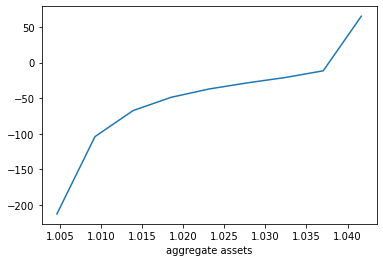

In [93]:
# Plotting A(R) as a fxn of R

A_vals = [A_R(R) for R in R_grid]
plt.plot(R_grid[1:], A_vals[1:])
plt.xlabel('R')
plt.xlabel('aggregate assets')

In [72]:
# function to find market-clearing R
def find_R(param=param_base):
    R_star = opt.brentq(A_R, 1, 1/β)
    return R_star

R_eqm = find_R()
R_eqm

1.0395783396681488

Text(0, 0.5, 'CDF')

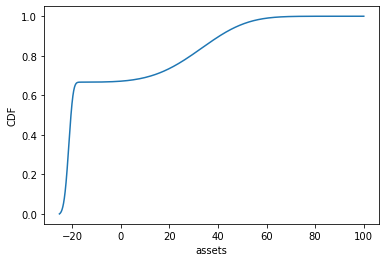

In [92]:
# Plotting equilibrium invariant distribution

r_eqm = R_eqm-1
amin_eqm = -1/max(r_eqm, 1e-5)
Va_eqm, a_policy_eqm, c_policy_eqm, param_eqm = backward(param={**param, 'r': r_eqm, 'amin': amin_eqm}) 
ma_grid_r_eqm = param_eqm['ma_grid']
T_eqm = make_T(a_policy=a_policy_eqm, Π= Π, ma_grid=ma_grid_r_eqm)
T_R_eqm = T_eqm.T # transpose to get transition operator
μ_eqm = get_mu(T_R_eqm) # get stationary distribution

a_vals = np.repeat(ma_grid_r_eqm[0], 2) # (ns*na)x1 vector showing a values for μ_eqm
a_dist = []
for a in ma_grid_r_eqm[0]: # iterate over a bins
    a_dist.append(μ_eqm[a_vals == a].sum())
# for each asset grid value, sum pop share across income states
a_CDF = np.cumsum(a_dist)
plt.plot(ma_grid_r_eqm[0], a_CDF)
plt.xlabel('assets')
plt.ylabel('CDF')


# QUESTIONS

* Plot eqm invariant distribution? Plotting assets for R = 1?
* How many values for R grid?


# Problem 3

In [94]:
# Setting up parameters
δ = 0.05
α = 0.3

param_base = {'δ': δ, 'α': α, 'r': r, 'β': β, 'γ': γ, 'yL': yL, 'θ': 0, 'x': 0, 'amin': 0}

0.03

In [ ]:
# Wages as fxn of R
def w(R, param=param_base):
    α = param['α']
    δ = param['δ']
    w = (1-α)*(α**(α/(1-α)))*((R-1+δ)**(-α/(1-α)))
    return w

In [ ]:
# Set up R grid
# Interest rate grid
nR = 10
R_grid = np.linspace(1,1/β, num=nR)

In [ ]:
# Here I provide a function that plots and saves results from different parameters

# initiate a subfolder in your working folder called "graphs" to store all results

# for each specification, plot consumption function, and saving function
# variable takes in a string, such as 'r', 'β', ..., which is the variable you vary
# values takes in a vector, which encodes different values you want to try
# filename takes in a string, which will be the file name
# display_na controls how many asset grids to show; default is to show all of them; set lower to see points close to amin
# param_base takes in the baseline specification, based on which you will only change on variable at a time
def plot_policy(variable, values, display_na=na, param_base=param_base):
    
    cmap = plt.get_cmap("tab10") # color scheme
    fig = plt.subplots(1,2,figsize=(14,5))
    
    plt.subplot(121)
    plt.title('consumption policy')
    for i, v in enumerate(values): #step through values of variable in interest
        param = {**param_base, variable: v} # alter parameter of interest
        Va, a_policy, c_policy, param = backward(param=param) # get policies and parameters
        a = param['a_grid'] # store grids from converged parameters
        s = param['s_grid']
        plt.plot(a[:display_na], c_policy[0,:display_na], color=cmap(i), linestyle='--',\
                 label=f'y={round(s[0],2)} under {variable}={round(v,2)}') # plot consumptions by assets
        plt.plot(a[:display_na], c_policy[1,:display_na], color=cmap(i), linestyle='-',\
                 label=f'y={round(s[1],2)} under {variable}={round(v,2)}')
    plt.legend()
    plt.ylabel('consumption policy $c$')
    plt.xlabel('saving from last period $a_-$')
    
    
    plt.subplot(122)
    plt.title('change in saving')
    for i, v in enumerate(values):
        param = {**param_base, variable: v}
        Va, a_policy, c_policy, param = backward(param=param)
        a = param['a_grid']
        s = param['s_grid']
        plt.plot(a[:display_na], a_policy[0,:display_na]-a, color=cmap(i), linestyle='--',\
                 label=f'y={round(s[0],2)} under {variable}={round(v,2)}')
        plt.plot(a[:display_na], a_policy[1,:display_na]-a, color=cmap(i), linestyle='-',\
                 label=f'y={round(s[1],2)} under {variable}={round(v,2)}') # plot savings by starting assets
    plt.legend()
    plt.ylabel('saving policy $a-a_-$')
    plt.xlabel('saving from last period $a_-$')
 
    plt.suptitle(f'Varying {variable} with values of {round(values,2)}')
    plt.tight_layout()
    return


In [ ]:
# Get asset policy for each interest rate
r_a_policies = [None]*nr
for i in range(nr):
    r = r_grid[i]
    Va, a_policy, c_policy, param = backward(param={**param_base, 'r': r})
    #print(a_policy)
    r_a_policies[i] = a_policy[0]

In [ ]:
μ_0 = ones((nr, ns, na))*(1/(ns*na)) # uniform distribution across income x asset states

In [ ]:
μ_1 = zeros((nr, ns, na)) # initialize next distribution

In [ ]:
def Q_transition(R, y, a)

In [ ]:
def iterate_μ1(μ_0, a_policies, nr=nr):
    for r in range(nr): #iterate over interest rates
        for s in range(ns): #iterate over STARTING income states
            for i in range(na):
                new_a_idx = np.where(ma_grid[s]==r_a_policies[r][i]) 
                    #given that you started with asset a1, a policy says you'll end up with assets a2. 
                    #new_a_idx is the index of a2 in ma_grid
                for new_s in range(ns):
                    μ_1[r, new_s, new_a_idx] += Π[s, new_s]*μ_0[r, s,i] 
                    # for the [new_s, a2] cell in μ_1, add prob that you were in [s, a1] x prob of moving from s -> new_s
                    # (given that policy maps a1 -> a2)
    return μ_1

#---------------

def iterate_μ(μ_0=μ_0, r_grid, error=error, imax=imax, param=param_base):
    # get asset policy for each interest rate
    nr = len(r_grid)
    r_a_policies = [None]*nr
    for i in range(nr):
        r = r_grid[i]
        Va, a_policy, c_policy, param = backward(param={**param, 'r': r})
        r_a_policies[i] = a_policy[0]
    
    old_μ = μ_0
    μ_1 = iterate_μ1(old_μ)
    e = np.max(np.abs(μ_1-old_μ))
    i = 1
    while e > error and i < imax:
        old_μ=μ_1
        μ_1 = iterate_μ1(old_μ, r_a_policies)
        e = np.max(np.abs(μ_1-old_μ))
        i+=1
    
    
    
    
    
    
    

In [ ]:
r_a_policies[0][500]

In [ ]:
np.where(ma_grid[1]==r_a_policies[0][500])

In [ ]:
# 4.3

#find index of closest value in array
def find_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [ ]:
# get policies using default parameters

# function to get consumption path
def get_paths(a_start, y, n, param=param_base):
    Va, a_policy, c_policy, param = backward(param=param) # get policies and parameters
    a = param['a_grid']
    s = param['s_grid']
    new_a = a_start
    new_y = y
    asset_path = ones(n)
    c_path = ones(n)
    for i in range(n):
        asset_path[i] = new_a
        a_idx = find_idx(a, new_a)
        y_idx = find_idx(s, new_y)
        new_c = c_policy[y_idx][a_idx]
        c_path[i] = new_c
        new_a = a_policy[y_idx][a_idx]
    return asset_path,c_path


def get_mpc(n, a_start, y_start, τ=0, param=param_base):
    a_path, c_path = get_paths(a_start, y_start, n, param=param)
    a_path_t, c_path_t = get_paths(a_start+τ, y_start, n, param=param)
    
    return c_path_t - c_path

print("yL, yL: ", get_mpc(n=5, a_start=yL, y_start=yL, τ=0.05))
print("2*yL, yL: ", get_mpc(n=5, a_start=2*yL, y_start=yL, τ=0.05))
print("yL, yH: ", get_mpc(n=5, a_start=yL, y_start=yH, τ=0.05))
print("2*yH, yH: ", get_mpc(n=5, a_start=2*yH, y_start=yH, τ=0.05))    



    
    
    

In [ ]:
# function to plot MPC

def plot_mpc(variable, values, τ=0, n=5, a_start=1.5, y_start=1, label = '', display_na=na, param_base=param_base):
    cmap = plt.get_cmap("tab10") # color scheme
    fig = plt.subplots()
    plt.title("MPC")
    
    for i, v in enumerate(values): #step through values of variable in interest
        param = {**param_base, variable: v} # alter parameter of interest
        mpc = get_mpc(n, a_start, y_start, τ, param=param)
        t_vals = [i+1 for i in range(n)]
        if label != '':
            plt.plot(t_vals, mpc, color=cmap(i), linestyle='--',\
                 label=label) # plot consumptions by assets
        else:
            plt.plot(t_vals, mpc, color=cmap(i), linestyle='--',\
                 label=f'{variable}={round(v,2)}') # plot consumptions by assets
    plt.legend()
    plt.ylabel('MPC')
    plt.xlabel('period')
    return

In [ ]:
#4.4

plot_mpc(variable='θ', values=[0], τ=0.05, n=5, a_start=yL, y_start=yL, label='yL, yL')
plot_mpc(variable='θ', values=[0], τ=0.05, n=5, a_start=2*yH, y_start=yL, label='2*yH, yL')
plot_mpc(variable='θ', values=[0], τ=0.05, n=5, a_start=yL, y_start=yH, label='yL, yH')
plot_mpc(variable='θ', values=[0], τ=0.05, n=5, a_start=2*yH, y_start=yH, label='2*yH, yH')

The figures above show that conditional on initial wealth, having a higher income lowers your MPC. This makes sense because the agent has less need to consume from the shock because their consumption from their regular income is higher, lowering their marginal propensity to consume. For the low income agent, having higher initial wealth lowers their MPC. This follows from the higher initial wealth keeping the agent away from their borrowing constraint, so they have a lower propensity to consume the shock. For the high income agent, having higher intial wealth raises their MPC. This could because they are sufficiently wealthy that saving is even less of a concern so they are more willing to consume the unexpected windfall.

In [ ]:
# 4.5

plot_mpc(variable='amin', values=linspace(amin_nbc, 0, 3), τ=0.05, n=5)

Moving the borrowing constraint up from the natural borrowing constraint to 0 increases the MPC. This is because raising the borrowing constraint means the agent is more likely have a binding borrowing constraint and having a binding constraint raises the marginal propensity to consume from a positive income shock.

In [ ]:
plot_mpc(variable='γ', values=linspace(0.5, 3, 3), τ=0.05, n=5)

Raising the risk aversion parameter from 0.5 to 3 decreases the MPC. This is because being more risk averse means theres a greater motivation to save a positive income shock to spread the consumption over future periods.

In [ ]:
plot_mpc(variable='r', values=linspace(0.01, 0.04, 3), τ=0.05, n=5)

A higher interest rate reduces the MPC. This makes sense because a higher interest rate increases returns to saving, so the agent will choose to consume less of the shock in each period.

In [ ]:
plot_mpc(variable='β', values=linspace(0.9, 0.97, 3), τ=0.05, n=5)

Being more heavily present biased (i.e., having a lower beta value) raises the MPC because a more impatient agent does not value future consumption as much as a more patient agent, so the former will consume more of the shock in early periods.

In [ ]:
plot_mpc(variable='x', values=linspace(-0.4, 0.4, 3), τ=0.05, n=5)

Reducing income variation (i.e., increasing x) reduces the MPC because holding y in the low income state, a larger x means a higher income so the individual is less likely to be up against their borrowin constraint and therefore has a lower expected MPC.

In [ ]:
plot_mpc(variable='θ', values=linspace(-0.04, 0.6, 3), τ=0.05, n=5)

Increasing the chance of changing income states (i.e., increasing theta) increases the MPC because with low income (as plotted aboce), having a higher chance of moving into the high income state means that the agent is more likely to consume a positive shock since they have a higher chance of having high income in the future.